In [10]:
import os
import tensorflow as tf

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
cwd = os.getcwd()

source_path = os.path.join(cwd, 'Fishku\\Fishku-MachineLearning-master\\Dataset')
train_path = os.path.join(source_path, "Eyes\\fish_kaggle\\train")
test_path = os.path.join(source_path, "Eyes\\fish_kaggle\\test")

In [3]:
# Directory with fresh/non-fresh training pictures
train_fresh_dir = os.path.join(train_path, "fresh")
train_nonfresh_dir = os.path.join(train_path, "non-fresh")

# Directory with fresh/non-fresh test pictures
test_fresh_dir = os.path.join(test_path, "fresh")
test_nonfresh_dir = os.path.join(test_path, "non-fresh")


train_fresh_fnames = os.listdir( train_fresh_dir )
train_nonfresh_fnames = os.listdir( train_nonfresh_dir )

print(train_fresh_fnames[:10])
print(train_nonfresh_fnames[:10])

# total numbers in training and test set

print(f"total training fresh images : {len(os.listdir(train_fresh_dir))}")
print(f"total training non-fresh images : {len(os.listdir(train_nonfresh_dir))}")
print()
print(f"total test fresh images : {len(os.listdir(test_fresh_dir))}")
print(f"total test non-fresh images : {len(os.listdir(test_nonfresh_dir))}")

['105_20200517_084015.jpg', '105_20200517_084316.jpg', '105_20200517_084357.jpg', '105_20200517_084411.jpg', '105_20200517_084438.jpg', '105_20200517_084451.jpg', '105_20200517_084532.jpg', '105_20200517_084549.jpg', '105_20200517_084637.jpg', '105_20200517_084646.jpg']
['105_20200517_145200.jpg', '105_20200517_145253.jpg', '105_20200517_145351.jpg', '105_20200517_145439.jpg', '105_20200517_145502.jpg', '105_20200517_145520.jpg', '105_20200517_145554.jpg', '105_20200517_145606.jpg', '105_20200517_145636.jpg', '105_20200517_145648.jpg']
total training fresh images : 213
total training non-fresh images : 211

total test fresh images : 55
total test non-fresh images : 57


In [4]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

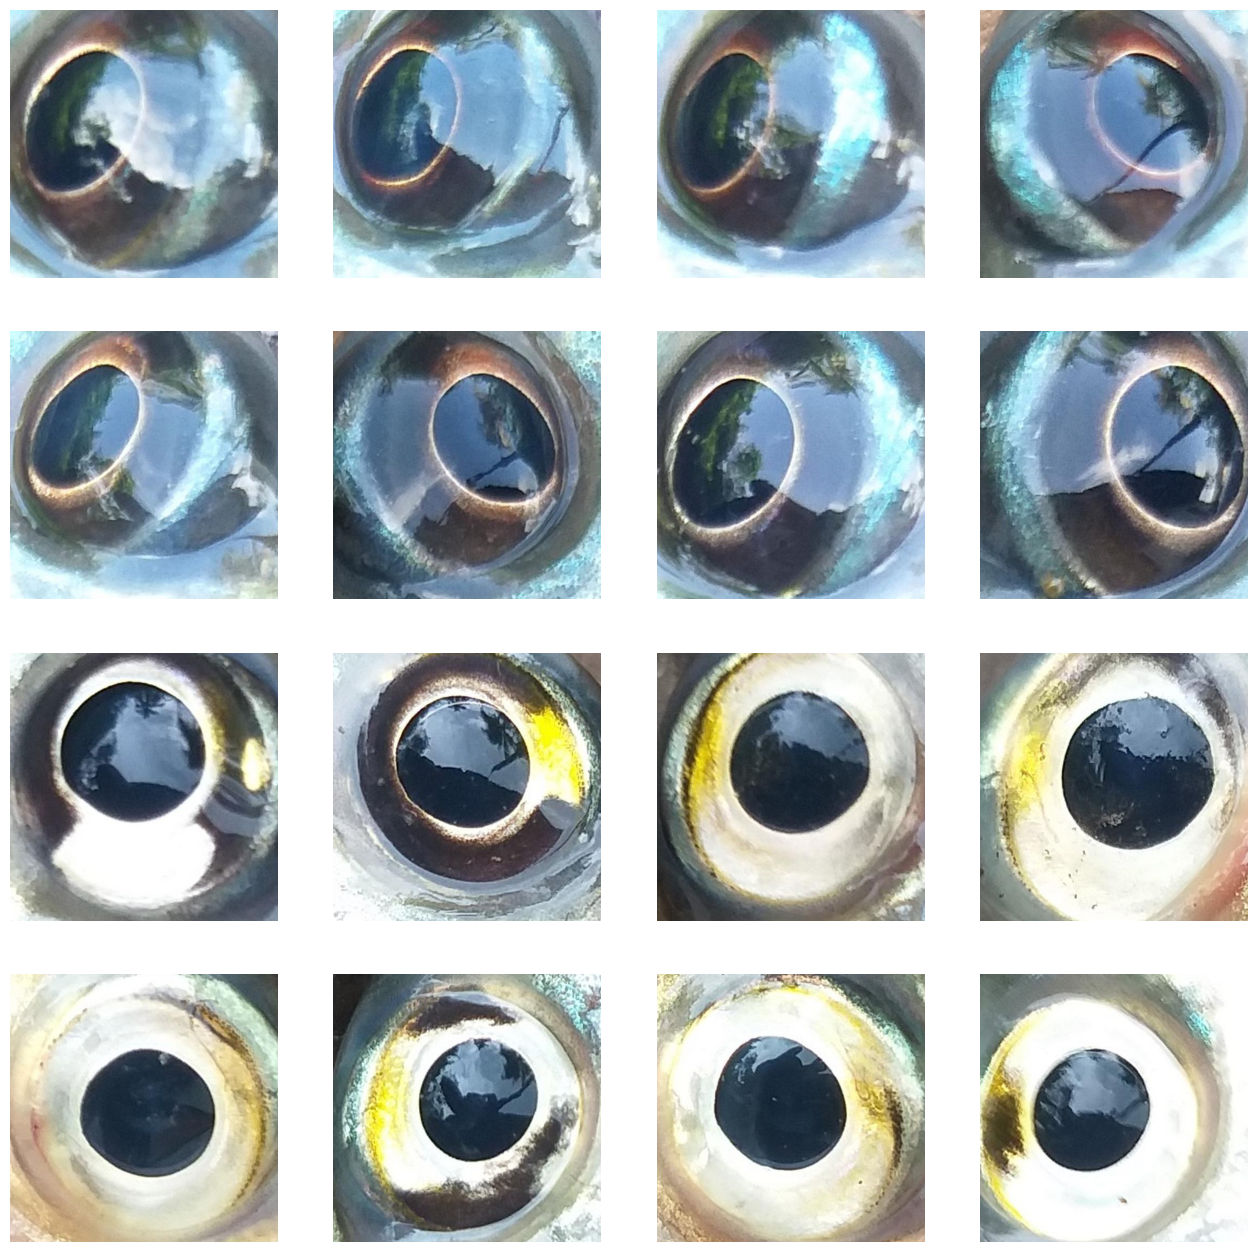

In [5]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_fresh_dir, fname) 
                for fname in train_fresh_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_nonfresh_dir, fname) 
                for fname in train_nonfresh_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# Data Preprocessing

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_generator(TRAIN_DIR, VALIDATION_DIR):
    
    """
    Pre-processing the image data using ImageDataGenerator
    and flow_from_directory.
    
    Input : 
        TRAIN_DIR (TRAINING  DATA DIRECTORY)
        VALIDATION_DIR(VALIDATION DATA DIRECTORY)
    
    Output :
        TRAIN_GENERATOR (Preprocessed Image from Training Dir)
        VAL_GENERATOR (Preprocessed Image from Validation Dir)
    """
    
    # Data Augmentation
    train_datagen = ImageDataGenerator(
          rescale=1./255,
          rotation_range=40,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest'
            )
    
    validation_datagen = ImageDataGenerator(rescale = 1/255.0)
    
    train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150)) 
    
    val_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))
    
    return train_generator, val_generator


train_generator, validation_generator = data_generator(train_path, test_path)

Found 424 images belonging to 2 classes.
Found 112 images belonging to 2 classes.


In [11]:
from tensorflow.keras import Model
def create_model():
    """
    Create an image classification model using InceptionV3 to
    predict whether a fish is fresh or not based on its eyes.
    """
    
    pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet')

    # Freeze the weights of the layers.
    for layer in pre_trained_model.layers:
      layer.trainable = False


    last_layer = pre_trained_model.get_layer('mixed7')
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    

    # last_output = pre_trained_model.output

    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(150, activation = 'relu')(x)
    x = tf.keras.layers.Dense(128, activation = "relu")(x)
    x = tf.keras.layers.Dense(64, activation = "relu")(x)
    x = tf.keras.layers.Dense(32, activation = "relu")(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)



    # Append the dense network to the base model
    model = Model(pre_trained_model.input, x)
    
    # Compile the model
    model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
    
    return model

In [12]:
model = create_model()

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    verbose=1)

last layer output shape:  (None, 7, 7, 768)
Epoch 1/10
22/22 [==============================] - 19s 723ms/step - loss: 0.3769 - accuracy: 0.8632 - val_loss: 0.1878 - val_accuracy: 0.9196
Epoch 2/10
22/22 [==============================] - 15s 673ms/step - loss: 0.2034 - accuracy: 0.9363 - val_loss: 0.0720 - val_accuracy: 0.9821
Epoch 3/10
22/22 [==============================] - 15s 679ms/step - loss: 0.1843 - accuracy: 0.9458 - val_loss: 0.0723 - val_accuracy: 0.9732
Epoch 4/10
22/22 [==============================] - 15s 675ms/step - loss: 0.1036 - accuracy: 0.9646 - val_loss: 0.1109 - val_accuracy: 0.9643
Epoch 5/10
22/22 [==============================] - 17s 769ms/step - loss: 0.1132 - accuracy: 0.9575 - val_loss: 0.1990 - val_accuracy: 0.9375
Epoch 6/10
22/22 [==============================] - 17s 799ms/step - loss: 0.1707 - accuracy: 0.9505 - val_loss: 0.2340 - val_accuracy: 0.9464
Epoch 7/10
22/22 [==============================] - 17s 778ms/step - loss: 0.0447 - accuracy: 0.98

Text(0.5, 1.0, 'Training and validation loss')

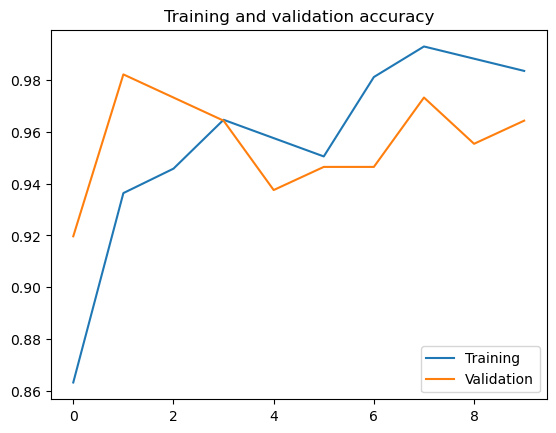

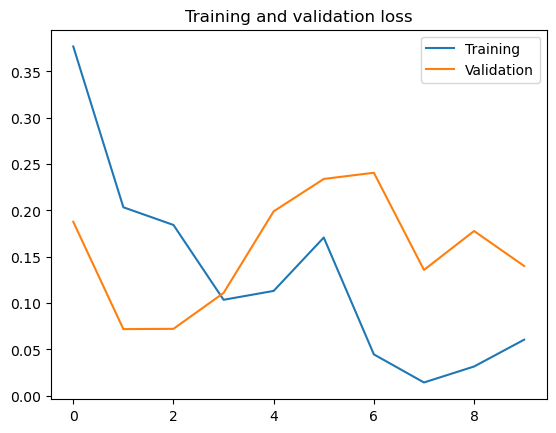

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

# Model Prediction

In [14]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

TEST_DIR = os.path.join(source_path, "Eyes\\images")


def model_prediction(model, TEST_DIR):
    
    """
    Classifying the images using InceptionV3 Model.
    
    Input :
        model : InceptionV3 model using create_model() function
        TEST_DIR : Directory that contains image that we want to predict
    Output:
        Fresh or Not-Fresh
    """
    
    # Getting the file inside TEST_DIR
    IMAGE = os.listdir(TEST_DIR)
    
    for i in IMAGE:
        
        path = os.path.join(TEST_DIR, i)

        img = load_img(path, target_size=(150,150))
        x = img_to_array(img)
        x = x / 255
        x = np.expand_dims(x, axis = 0)

        images = np.vstack([x])
        classes = model.predict(images, batch_size=20)
        print(classes[0])
        if classes[0]>0.5:
            print(i + " is fresh")
        else:
            print(i + " is  not fresh")
            
model_prediction(model, TEST_DIR)

1/1 [==============================] - 1s 841ms/step
[0.00237844]
D (10).jpg is a not fresh
1/1 [==============================] - 0s 40ms/step
[0.00018923]
D (9).jpg is a not fresh
1/1 [==============================] - 0s 36ms/step
[0.91148925]
G (10).jpg is fresh
1/1 [==============================] - 0s 36ms/step
[0.02460169]
G (9).jpg is a not fresh


In [ ]:
import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys(): 
    # predicting images
    path='/content/' + fn
    img=load_img(path, target_size=(150, 150))

    x=img_to_array(img)
    x /= 255
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=10)

    print(classes[0])

    if classes[0]>0.5:
        print(fn + " is a dog")
    else:
        print(fn + " is a cat")

In [12]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

os.path.join(source_path, "Eyes\\images")
images = os.listdir(images_dir)

print(images)

for i in images:
    path = os.path.join(images_dir, i)
    
    img = load_img(path, target_size=(150,150))
    x = img_to_array(img)
    x = x / 255
    x = np.expand_dims(x, axis = 0)
    
    images = np.vstack([x])
    classes = model.predict(images, batch_size=20)
    print(classes[0])
    if classes[0]>0.5:
        print(i + " is fresh")
    else:
        print(i + " is a not fresh")

['D (10).jpg', 'D (9).jpg', 'G (10).jpg', 'G (9).jpg']
1/1 [==============================] - 0s 56ms/step
[0.00031915]
D (10).jpg is a not fresh
1/1 [==============================] - 0s 49ms/step
[0.00012188]
D (9).jpg is a not fresh
1/1 [==============================] - 0s 53ms/step
[0.9997473]
G (10).jpg is fresh
1/1 [==============================] - 0s 52ms/step
[0.9795539]
G (9).jpg is fresh


In [ ]:
# CODE BLOCK FOR OLDER VERSIONS OF SAFARI

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

images_dir = os.path.join(source_path, "Eyes\\images")
images = os.listdir(images_dir)

print(images)

for i in images:
    print()
    # predicting images
    path = '/tmp/images/' + i
    img = load_img(path, target_size=(150, 150))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(i + " is a dog")
    else:
        print(i + " is a cat")